# Quick start

## Installation

The Python module can be directly installed from [PyPI](https://pypi.org/project/anta-database/) with:


This Python module is designed to query and visualized data in a AntADatabase folder. This folder has to be downloaded, contact me for access.
You can already have a look at this guide to have an idea of the features of this tool.


## Browsing the database

First, initialize the Database class by providing the full path to the AntADatabase:

In [1]:
from anta_database import Database

db = Database('/home/anthe/documents/data/isochrones/AntADatabase/')

Use the query() function to browse the database. 'query()' without argument will return all metadata contained in the database:

In [2]:
db.query()

Metadata from query:

  - author:
    Franke_2025
    Beem_2021
    Cavitte_2020
    Wang_2023
    Sanderson_2024
    Winter_2018

  - age:
    4700 4800 7200 10000 10700 11100 15400 16800 25600 29100 29300 31400 36300 37600 38000 38100 46600 48000 51400 52200 72500 73100 73400 74000 75300 81900 90000 91000 93900 95500 97400 108600 122800 128800 135600 159600 161000 162000 165200 169100 199700 219500 253400 278000 326800 340400 367800 400000 420000 483000 516000 559000 610000 705000

  - var:
    BedElev
    IceThk
    SurfElev

  - trace_id:
    20181226_01_012 EPICA_VI_35 A10BDLRSAR_9MI_10 19983206 IRH_20172040 20033143 20181227_01_001 20181226_02_010 20181227_02_006 V03E-2V03B 20181227_02_007 20231211_01_007 19972307 EPICA_IV_15 20022116 20181226_02_008 A68B_DLRSAR_9MI IRH_20172039 20181226_01_003 19983208 OIA_JKB2n_Y86a 20231211_01_021 IRH_20172047 20053109 ASB_JKB1a_R08Ec RAID-2V11E OIA_JKB2n_Y25a 20181227_02_002 HRB7-HRB8 A67_DLRSAR_9MI 19983205 RSAR_9MI_clipped WSB_JKB2h_R40b 20

The query() function takes as argument:
- author: author(s) of the datasets of interest
- age: age(s) in yrs before present of the layer(s) of interest
- var: variables(s) other than age depth such as 'IceThk', 'SurfElev' or 'BedElev'
- trace_id: ID of a particular trace. This is useful for explicit trace IDs such as 'DC_LDC_DIVIDE'

One can also combine field queries as well as providing lists. Here are a few examples:

In [4]:
#Examples of queries:
db.query(author='Cavitte_2020') # all data from Cavitte et al. 2020
db.query(age='38100') # all datasets with the 38.1ka isochrone
db.query(var='IceThk') # all datasets with IceThk variable
db.query(trace_id='DC_LDC_DIVIDE') # all layers with the trace ID DC_LDC_DIVIDE
db.query(author=['Franke_2025', 'Winter_2018'], age='38100') # example of multiple criteria

Metadata from query:

  - author:
    Franke_2025
    Winter_2018

  - age:
    38100

  - var:

  - trace_id:
    20181227_02_008 19993131 20181226_01_012 EPICA_VII_26 EPICA_VI_35 20181226_02_004 20231211_02_010 19983101 20023105 19972405 19983206 19972304 20231211_02_003 19972313 20113119 20181227_03_005 20181227_03_004 20023152 20033143 20181226_01_004 20022107 20231211_01_008 20181226_01_008 20173003 19993127 20181226_02_010 EPICA_IV_22 EPICA_VI_34 19993137 20181226_03_002 20231204_01_010 EPICA_II_08 20231211_01_015 20231211_02_021 19972206 20181227_02_006 20231211_02_017 EPICA_IV_23 20231129_01_006 20181227_02_007 20231211_01_007 19972307 20023115 20231211_01_023 DoCo_2007_08_12 20231211_01_022 20022116 19983402 EPICA_IV_15 EPICA_VIII_23 20181226_02_008 20231211_02_004 20013121 20181226_01_003 20231211_01_006 20231211_01_020 20023150 20231211_01_021 20231129_01_014 19993122 20053109 20181226_01_002 19972406 DoCo_2007_08_07 20023120 20231211_02_005 19993116 19973310 19983202 202312

## Visualization

Use the results of the query in the plotting functions:

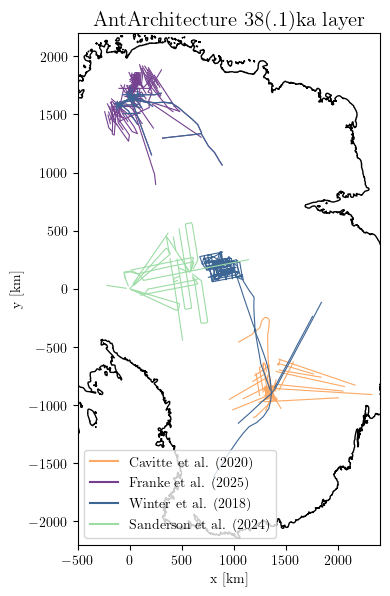

In [3]:
results = db.query(age=['38100','38000'])
db.plotXY(results,
                downscale_factor=1000, # downscale the datasets n times, which makes no visual difference but it is much lighter
                title='AntArchitecture 38(.1)ka layer',
                xlim=(-500, 2400), ylim=(-2200, 2200), # set the plot extent in km
                scale_factor=0.5, # adjust the size of the plot
                latex=True, # use latex compilers for plotting if you have them installed on your system
                # save='AntA_38ka.pdf', # Uncomment to save the figure, otherwise it we visualize with pyplot
                )

## Generate data from the database

Note: This part could be developed further in the future if there is the need. But for now, I am designing a separate Python module for constraining my ice sheet model of use, which is tailored to this database and other parallel processing libraries.

The data_generator() function reads the query and 'yield' the dataframes for later use.
Here is a quick example of how this can be used for computing the mean layer depth:

In [5]:
results = db.query(age=['38100'])
lazy_dfs = db.data_generator(results)

import numpy as np
mean_depth_trs = []
for df, md in lazy_dfs:
    mean_depth_trs.append(np.mean(df['38100']))

mean_depth = np.mean(mean_depth_trs)
print('The mean depth of the 38.1ka isochrone across East Antarctica is', mean_depth, 'm')

The mean depth of the 38.1ka isochrone across East Antarctica is 1127.8887185238113 m


In the for loop, 'df' is an individual dataframe from the database, corresponding to a single layer of a single trace from a single dataset. The 'md' stores the unique metadata from the current 'df'. One can then associate the metadata with the current df, for example:

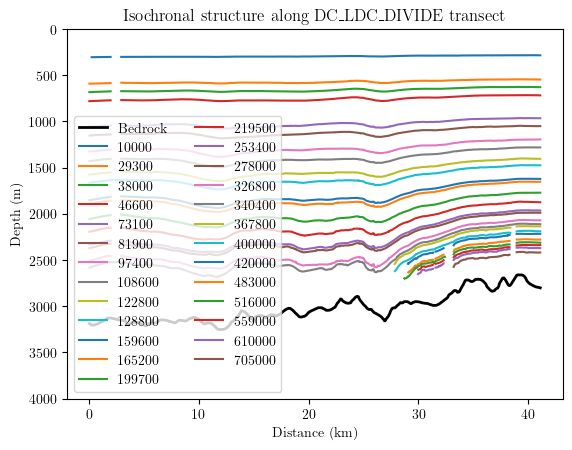

In [6]:
results = db.query(author='Cavitte_2020', trace_id='DC_LDC_DIVIDE')
lazy_dfs = db.data_generator(results)

import matplotlib.pyplot as plt
# from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True) # Do you use latex?

for df, md in lazy_dfs:
    if md['age'] is not None:
        plt.plot(df.distance/1000, df[md['age']], label=md['age'])
    if md['var'] == 'IceThk':
        plt.plot(df.distance/1000, df['IceThk'], linewidth=2, color='k', label='Bedrock')

plt.legend(ncol=2)
plt.xlabel('Distance (km)')
plt.ylabel('Depth (m)')
plt.ylim(4000, 0)
plt.title('Isochronal structure along DC_LDC_DIVIDE transect')
plt.show()

### Downscale the data

The downscale_factor argument in the data_generator reduces the size of the generated data by n times. This is useful when dealing with large data where the downscaling has a neglectable influence on the results.
Another solution, probably more straightforward, is the downsample_distance option, which allows to provide a distance in meters by which the data should be average along the transects:

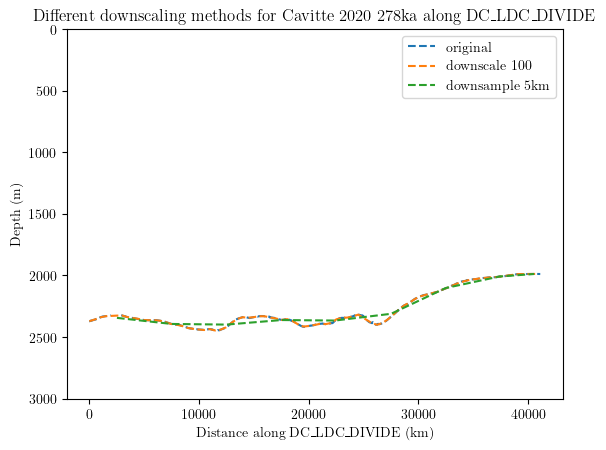

In [7]:
import matplotlib.pyplot as plt

results = db.query(author='Cavitte_2020', age='278000', trace_id='DC_LDC_DIVIDE')
original = db.data_generator(results)
downscale_10 = db.data_generator(results, downscale_factor=100)
downsampled_by_distance = db.data_generator(results, downsample_distance=5000)

list = [original, downscale_10, downsampled_by_distance]
labels = ['original', 'downscale 100', 'downsample 5km']

for i, lazy_dfs in enumerate(list):
    for df, md in lazy_dfs:
        plt.plot(df.distance, df['278000'],label=labels[i], linestyle='--')

plt.ylim(3000, 0)
plt.xlabel('Distance along DC_LDC_DIVIDE (km)')
plt.ylabel('Depth (m)')
plt.legend()
plt.title('Different downscaling methods for Cavitte 2020 278ka along DC_LDC_DIVIDE')
plt.show()